## 1. Packages

In [2]:
using Distributed
if nworkers() == 1
    addprocs(10)
end
using LaTeXStrings
using Plots
using Measures
@everywhere begin
    using Graphs, StatsBase, Random, Statistics
end

## 2. Build Network and setup contagion simulation



In [3]:
# Simulate the contagion process on a Watts-Strogatz small-world graph
@everywhere function simulate_contagion(complex_contagion::Bool,
    prob_infection::Float64,
    rewiring_prob::Float64;
    num_nodes::Int=500,
    k::Int=4)

    # Initialize the graph and infections

    # Create a Watts-Strogatz small-world graph
    g = watts_strogatz(num_nodes, k, rewiring_prob)
    infected = falses(num_nodes)

    seed = rand(1:num_nodes) # Select a random seed node
    nbrs = neighbors(g, seed) # Get neighbors of the seed node
    isempty(nbrs) && return (0.0, 0) # If no neighbors, return 0% infected and 0 ticks
    seed2 = rand(nbrs) # Select a random neighbor of the seed node

    infected[seed] = true # Infect the seed node
    infected[seed2] = true  # Infect a neighboring node

    prev_count = 0
    curr_count = count(infected)
    ticks = 0

    while curr_count != prev_count && curr_count < num_nodes # Continue until no new infections or all nodes are infected
        prev_count = curr_count

        infected_start = findall(infected)
        shuffle!(infected_start)

        for u in infected_start # Iterate over currently infected nodes
            for v in neighbors(g, u) # Check each neighbor
                if !infected[v] # If neighbor is not infected
                    if !complex_contagion || (count(w -> infected[w], neighbors(g, v)) > 1) # Check for complex contagion or simple contagion
                        if rand() <= prob_infection # Infection occurs with given probability
                            infected[v] = true
                        end
                    end
                end
            end
        end

        curr_count = count(infected)
        ticks += 1
    end

    percent = 100.0 * curr_count / num_nodes # Calculate percentage of infected nodes
    return (percent, ticks)
end


## 3. Parameters



In [4]:
rewiring_vals = vcat(0.0, sort([m * 10.0^k for k in -3:0 for m in 1:9 if m * 10.0^k <= 1.0]))  # Rewiring probabilities from 0 to 1 in logarithmic steps
complex_vals = (false, true)
p_infect = 1.0
trials = 100
combinations = [(cc, rw) for cc in complex_vals for rw in rewiring_vals];

## 4. Run Simulation



In [5]:
# Run multiple trials and collect statistics
@everywhere function sweep(combo, p_infect::Float64, trials::Int)
    cc, rw = combo
    perc_list = Vector{Float64}(undef, trials)
    ticks_list = Vector{Int}(undef, trials)
    @inbounds for i in 1:trials
        perc, t = simulate_contagion(cc, p_infect, rw)
        perc_list[i] = perc
        ticks_list[i] = t
    end

    return (
        complex_contagion=cc,
        rewiring_prob=rw,
        avg_percent=mean(perc_list),
        perc_list=perc_list,
        avg_ticks=mean(ticks_list),
        ticks_list=ticks_list
    )
end

results = pmap(c -> sweep(c, p_infect, trials), combinations);

## 5. Plot 9.12(a)


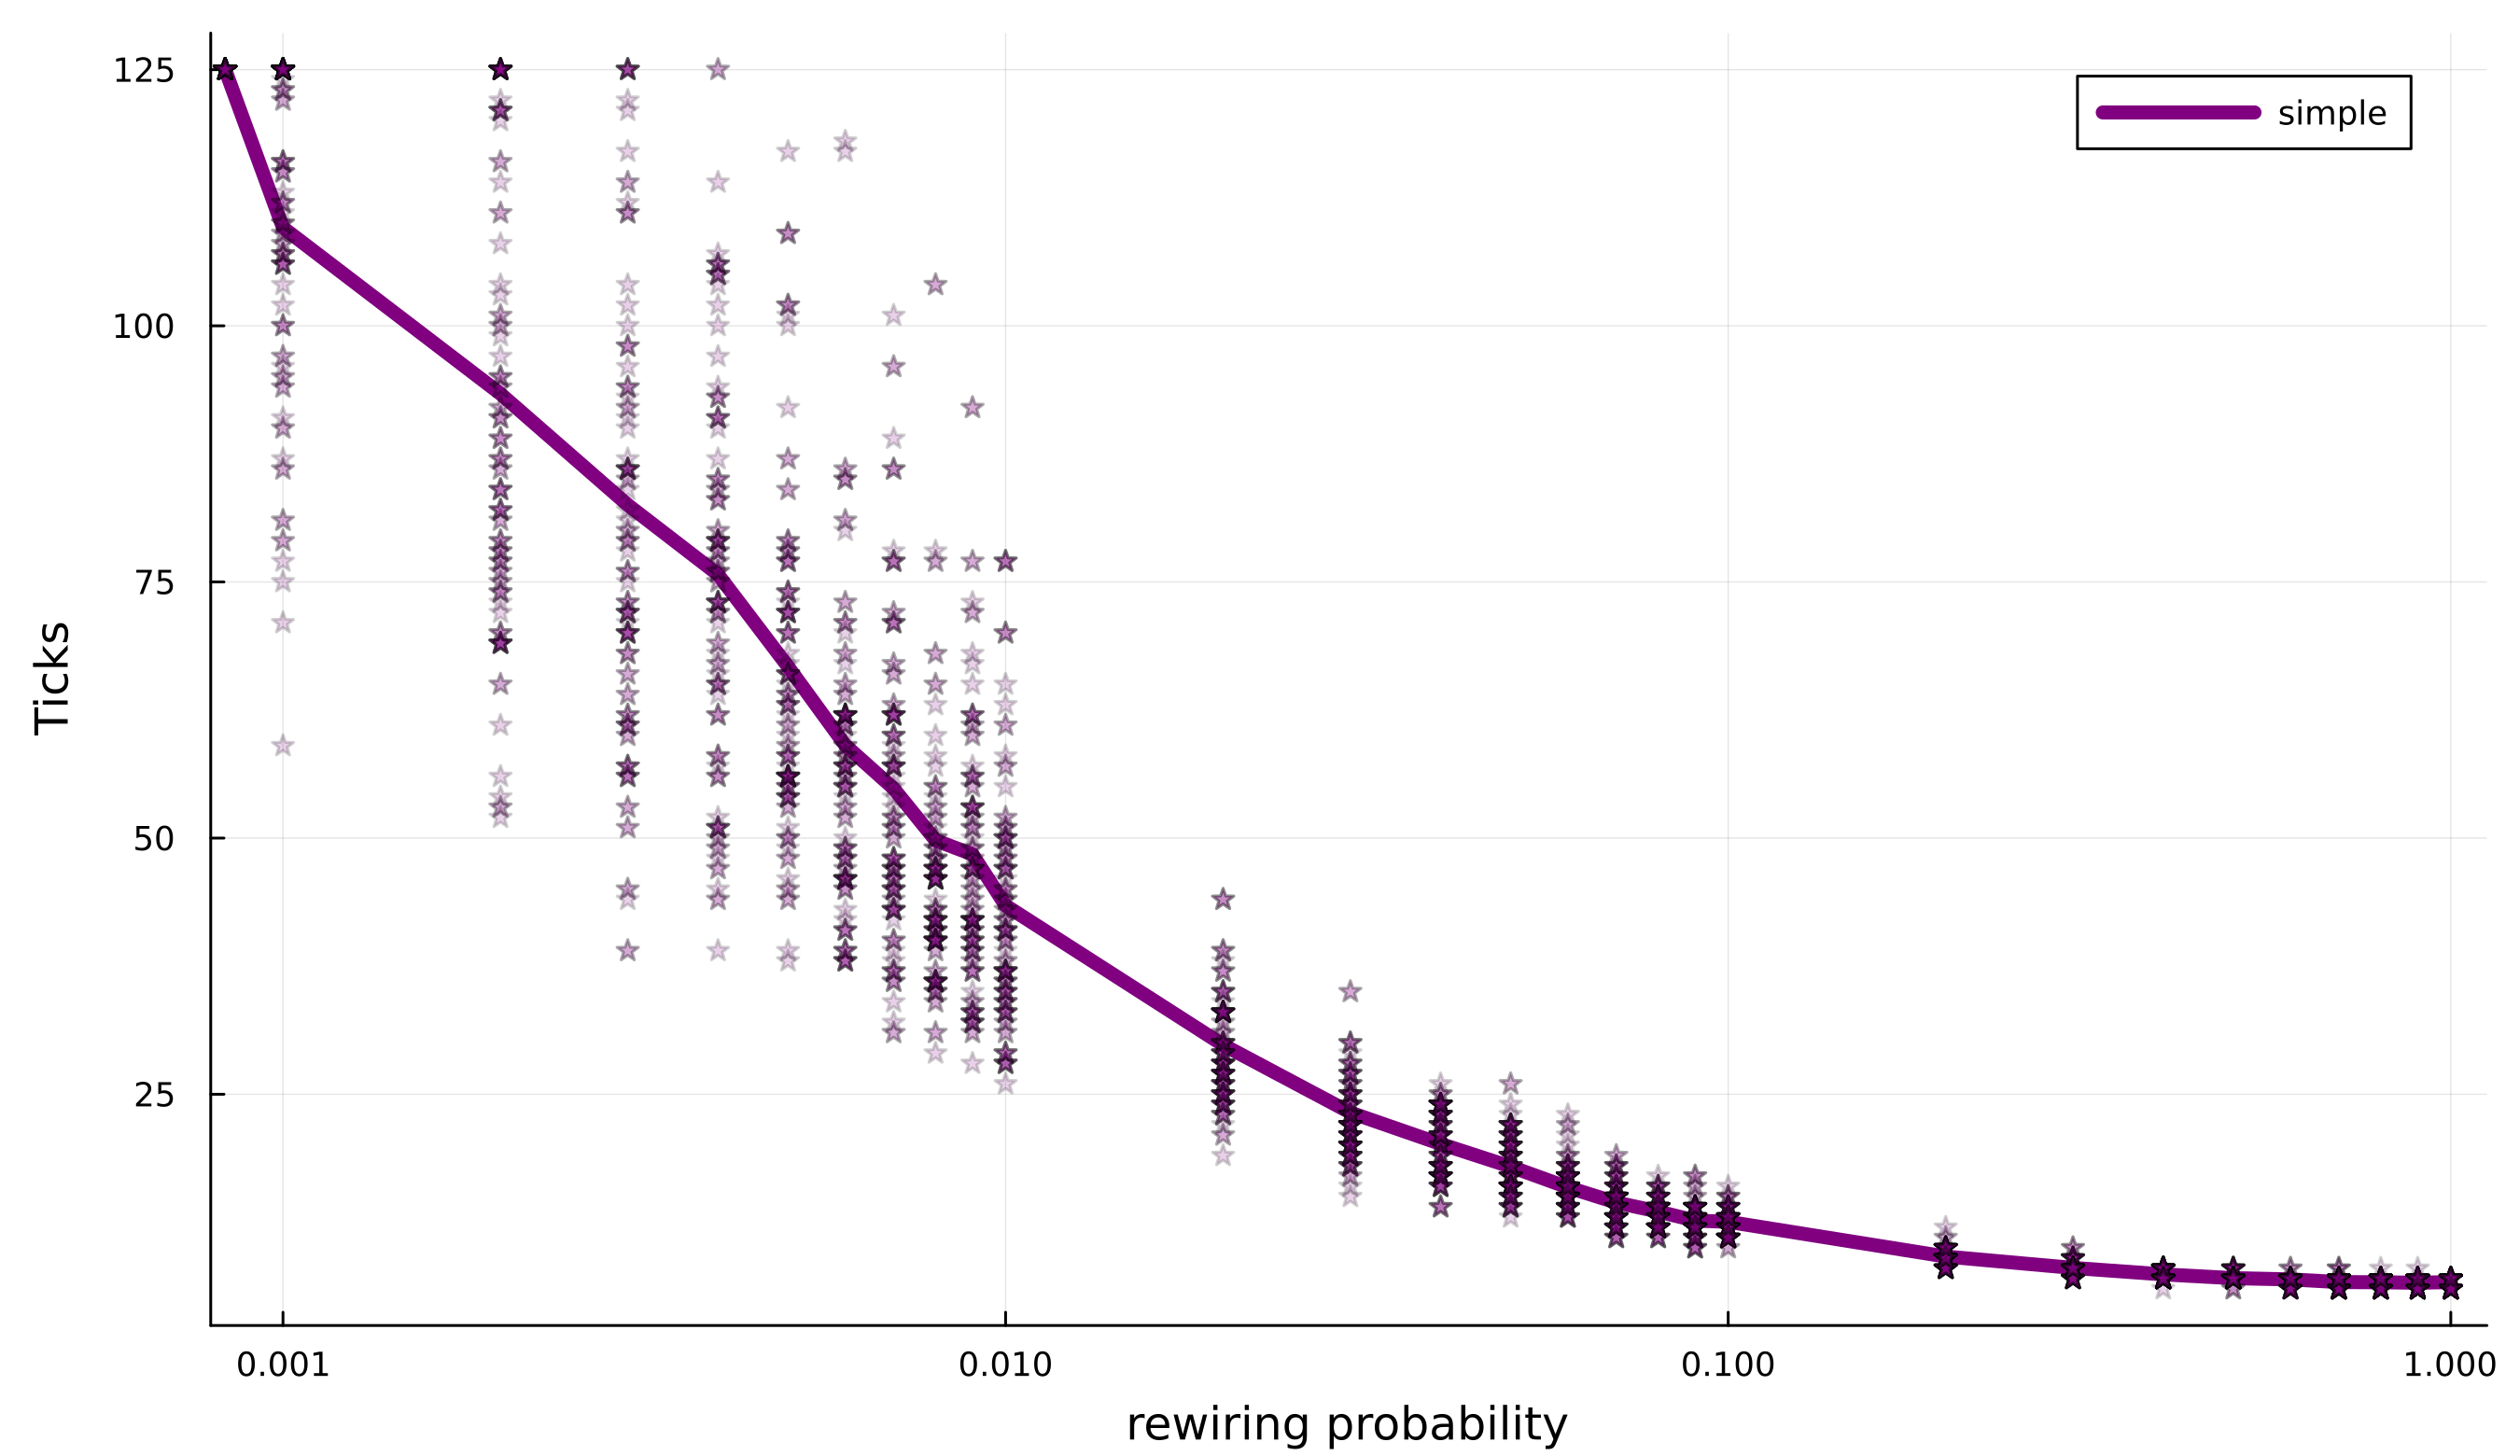

In [ ]:
plot_n = 100 # Number of individual trial points to plot for each condition 


case_colors = Dict(false => :purple, true => :orange) # colors for simple and complex contagion
case_labels = Dict(false => "simple", true => "complex") # labels for simple and complex contagion
case_shapes = Dict(false => :star, true => :circle) # marker shapes for simple and complex contagion


rw0 = 10^-3
δ = 0.08
x1 = log10(rw0)
x0 = x1 - δ # Linear scale up to rw0, then logarithmic scale beyond that

# Custom x-axis to fit both linear and logarithmic scales
xmap(rw) = (rw <= rw0) ? (x0 + (rw / rw0) * (x1 - x0)) : log10(rw)
xtick_vals = [1e-3, 1e-2, 1e-1, 1.0]
xtick_pos = xmap.(xtick_vals)
xtick_labels = ["0.001", "0.010", "0.100", "1.000"]

# Plot ticks to reach full contagion vs. rewiring probability
plt_ticks = plot(
    xticks=(xtick_pos, xtick_labels),
    xlims=(x0 - 0.02, log10(1.0) + 0.05),
    xlabel="rewiring probability",
    ylabel="Ticks",
    dpi=300,
    legend=:topright,
    size=(900, 520),
    left_margin=5mm,
    bottom_margin=2mm,
)

for cc in (false) # Loop over contagion types
    subset = filter(r -> r.complex_contagion == cc, results)
    s = sort(subset, by=r -> r.rewiring_prob)
    rw_line = [r.rewiring_prob for r in s]
    mean_line = [r.avg_ticks for r in s]
    plot!(plt_ticks, xmap.(rw_line), mean_line;
        lw=5, color=case_colors[cc], label=case_labels[cc])

    xs = Float64[]
    ys = Int[]


    for r in s # Scatter individual trial data points
        ts = r.ticks_list
        m = length(ts)
        nkeep = min(plot_n, m)
        idx = rand(1:m, nkeep)
        xval = xmap(r.rewiring_prob)
        append!(xs, fill(xval, nkeep))
        append!(ys, ts[idx])
    end

    scatter!(plt_ticks, xs, ys;
        ms=4, markeralpha=0.18,
        color=case_colors[cc], marker=case_shapes[cc], label=false)
end

display(plt_ticks)


## 6. Plot 9.12(b)



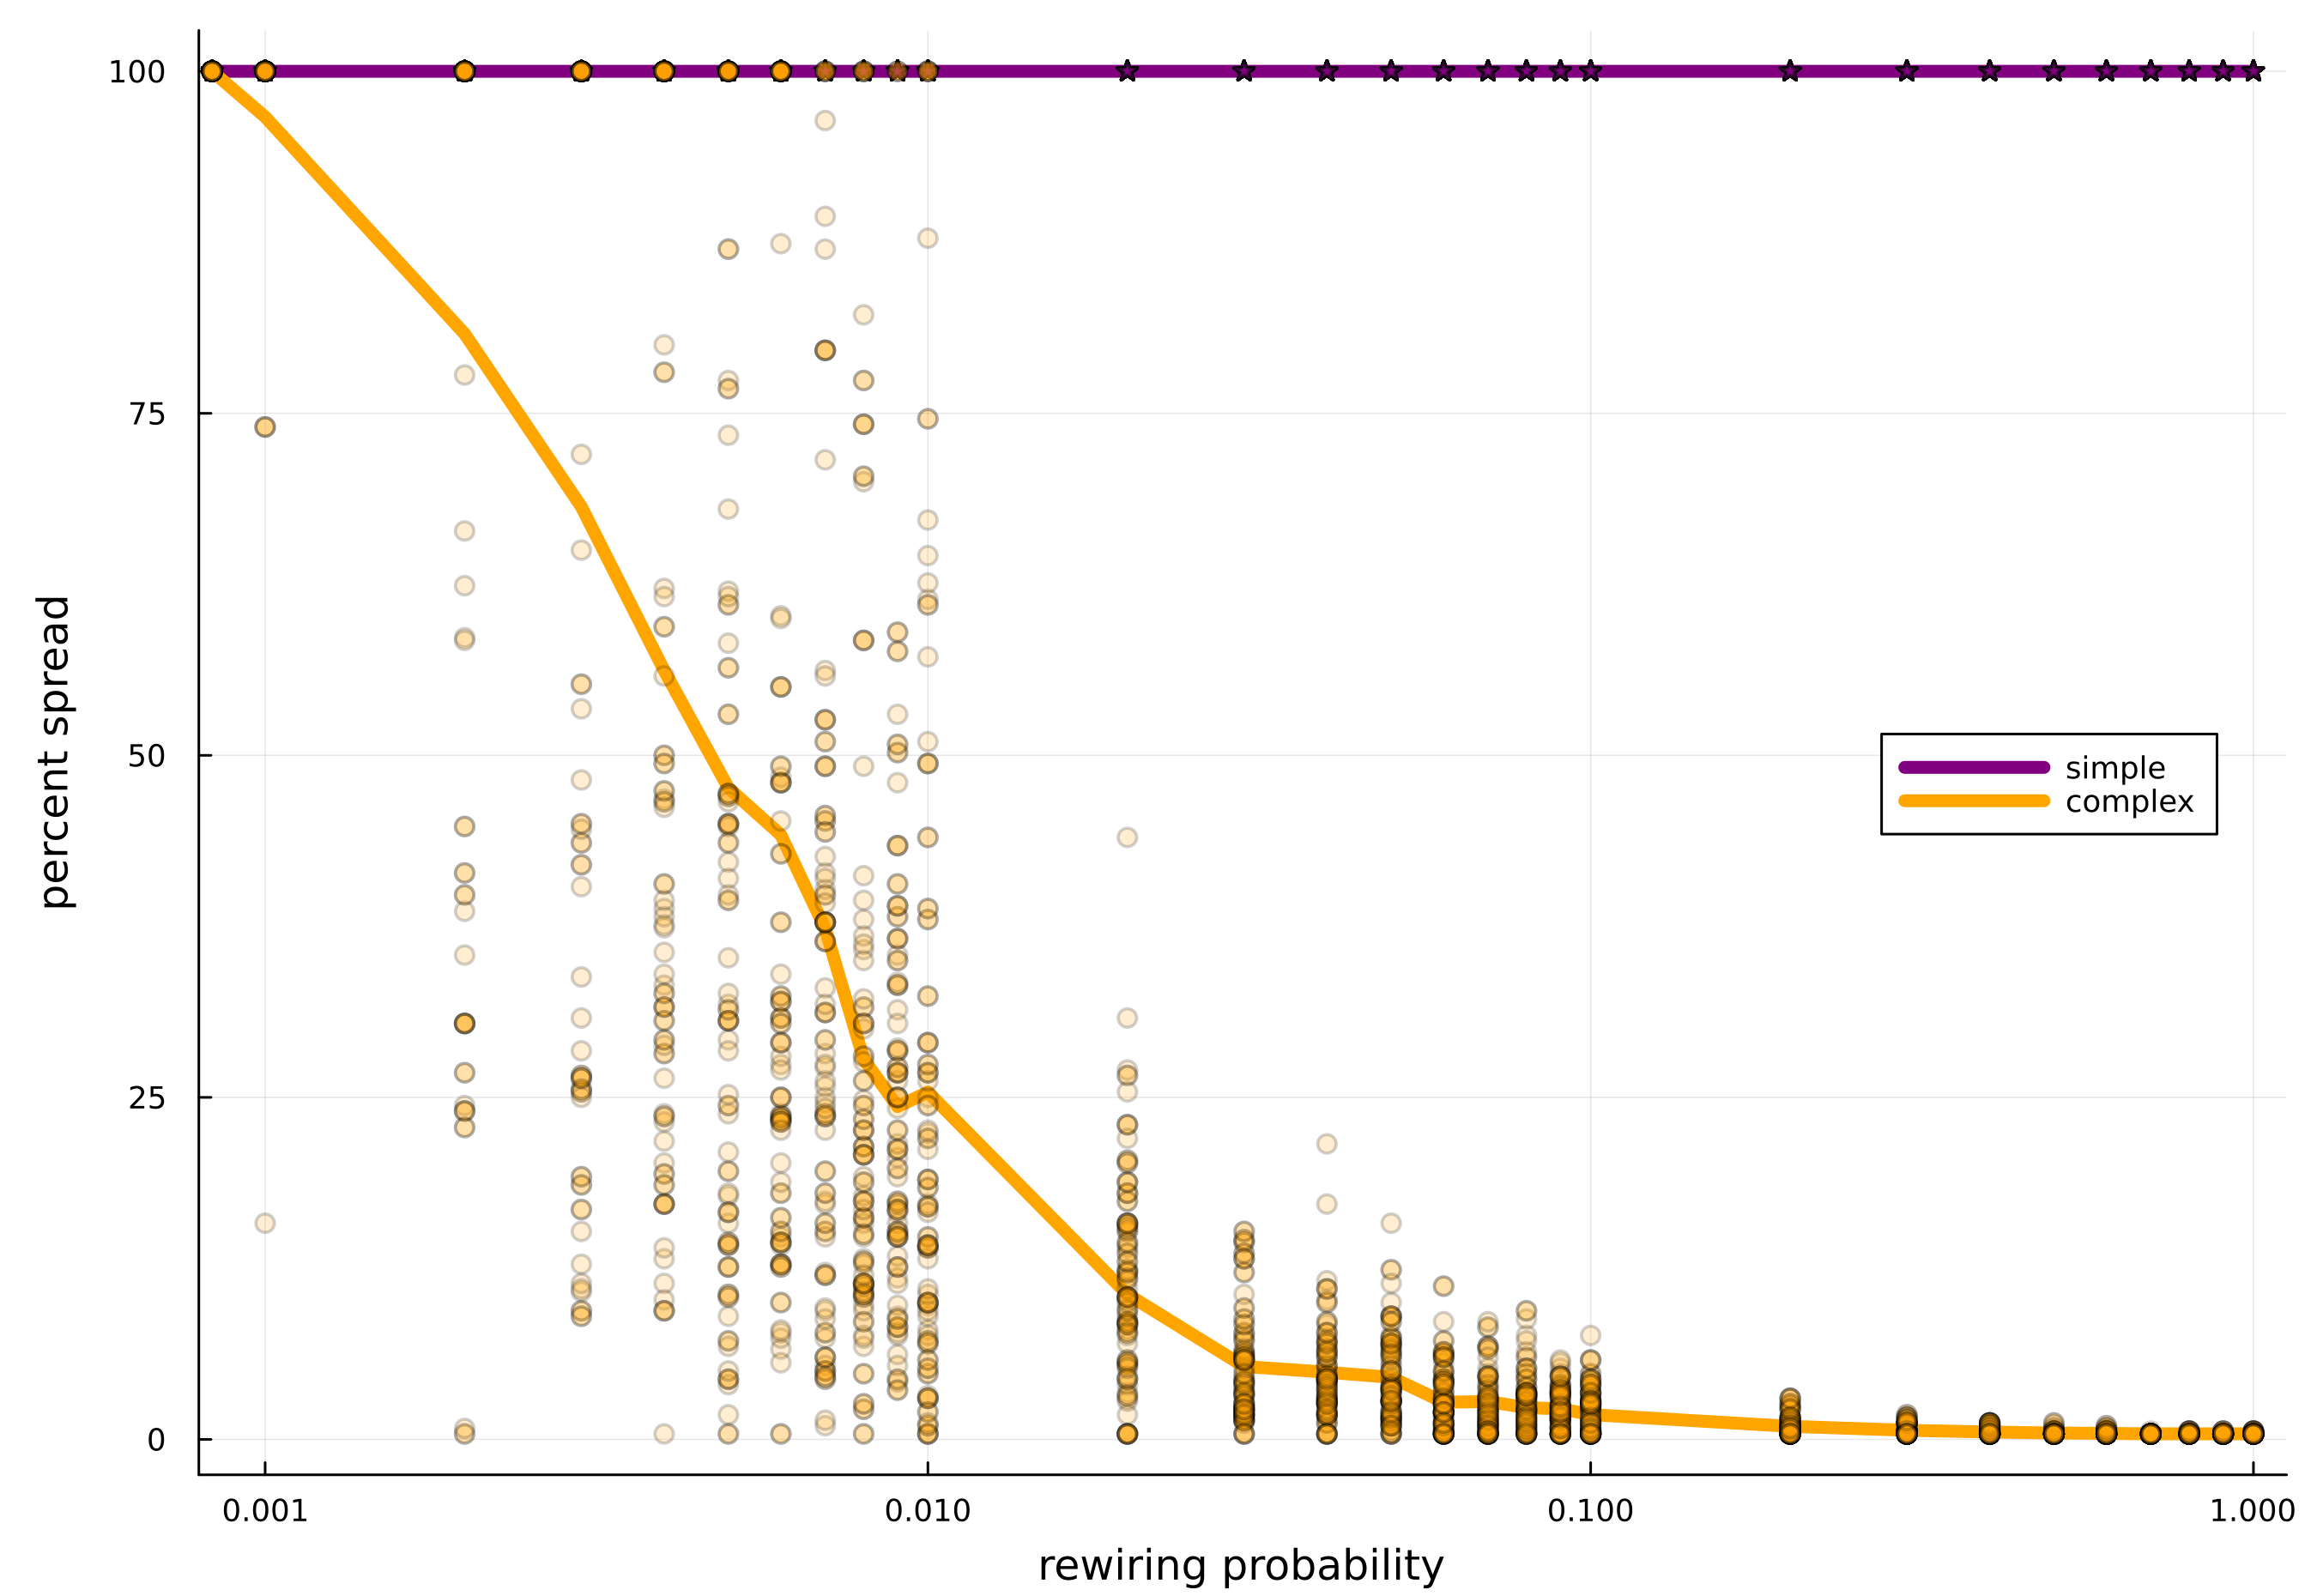

In [7]:
plot_n = 100


case_colors = Dict(false => :purple, true => :orange)
case_labels = Dict(false => "simple", true => "complex")
case_shapes = Dict(false => :star, true => :circle)

rw0 = 10^-3
δ = 0.08
x1 = log10(rw0)
x0 = x1 - δ

xmap(rw) = (rw <= rw0) ? (x0 + (rw / rw0) * (x1 - x0)) : log10(rw)

xtick_vals = [1e-3, 1e-2, 1e-1, 1.0]
xtick_pos = xmap.(xtick_vals)
xtick_labels = ["0.001", "0.010", "0.100", "1.000"]

plt_spread = plot(
    xticks=(xtick_pos, xtick_labels),
    xlims=(x0 - 0.02, log10(1.0) + 0.05),
    xlabel="rewiring probability",
    ylabel="percent spread",
    dpi=300,
    legend=:right,
    size=(900, 620),
    left_margin=5mm,)

for cc in (false, true)
    subset = filter(r -> r.complex_contagion == cc, results)
    s = sort(subset, by=r -> r.rewiring_prob)

    # mean curve
    rw_line = [r.rewiring_prob for r in s]
    mean_line = [r.avg_percent for r in s]
    plot!(plt_spread, xmap.(rw_line), mean_line;
        lw=5, color=case_colors[cc], label=case_labels[cc])

    # scatter subset of stored trials
    xs = Float64[]
    ys = Float64[]
    

    for r in s
        ts = r.perc_list
        m = length(ts)
        nkeep = min(plot_n, m)
        idx = rand(1:m, nkeep)
        xval = xmap(r.rewiring_prob)
        append!(xs, fill(xval, nkeep))
        append!(ys, ts[idx])
    end

    scatter!(plt_spread, xs, ys;
        ms=4, markeralpha=0.18,
        color=case_colors[cc], marker=case_shapes[cc], label=false)
end

display(plt_spread)
